In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
from scipy.interpolate import interp1d
from scipy.signal import correlate
from scipy.fftpack import fft,ifft
import time

import warnings
warnings.filterwarnings('ignore')

## Load Neural Data (single voxel, 30,456 samples, aquired at 1.88Hz, zscored)

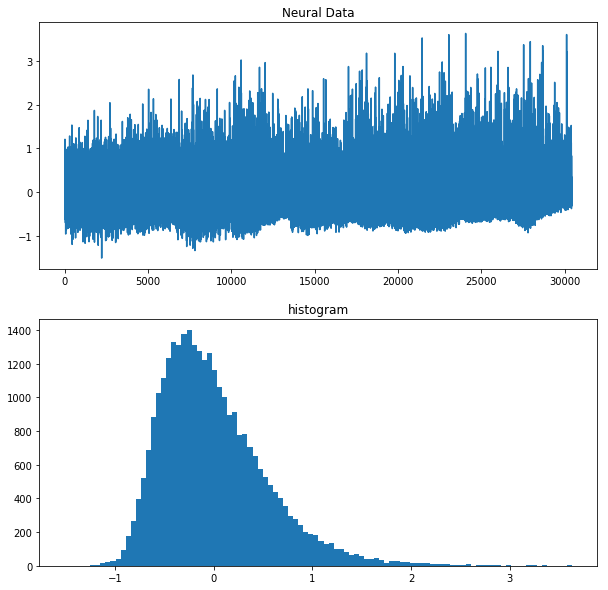

In [2]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/Y.npy'
neural = np.load(load_file)
plt.figure(figsize=(10,10))
plt.subplot(211);
plt.plot(neural);
plt.title('Neural Data');
plt.subplot(212)
plt.hist(neural,bins=100);
plt.title('histogram');

## Load Behavior (forward velocity, 810,000 samples, aquired at 50Hz)

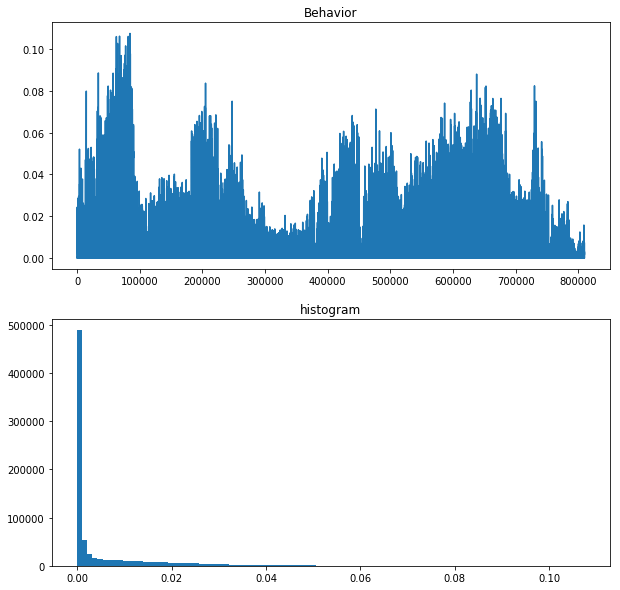

In [3]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/20210525_all_beh.npy'
behavior = np.load(load_file)
behavior = np.clip(behavior,0,None)
behavior = np.nan_to_num(behavior)

plt.figure(figsize=(10,10))
plt.subplot(211);
plt.plot(behavior);
plt.title('Behavior');
plt.subplot(212)
plt.hist(behavior,bins=100);
plt.title('histogram');

In [4]:
behavior_norm = behavior - np.mean(behavior)

## Load Behavior and Neural Timestamps; use to upsample neural to match behavior

In [5]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_timestamps_z_t.npy'
neural_timestamps = np.load(load_file)
neural_timestamps = neural_timestamps[:,29]
print(neural_timestamps.shape)

(30456,)


In [6]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/20210525_all_beh_time.npy'
behavior_timestamps = np.load(load_file)
print(behavior_timestamps.shape)

(810000,)


In [7]:
neural_interp_obj = interp1d(neural_timestamps, neural, bounds_error=False)
neural_upsampled = neural_interp_obj(behavior_timestamps)
neural_upsampled = np.nan_to_num(neural_upsampled)
print(neural_upsampled.shape)

(810000,)


# Calculate auto and cross corr

In [8]:
window = 500 # this is 10 sec wide
top = 0
bot = 0
for i in range(len(behavior)-window):
    beh = behavior_norm[i:i+window]
    neu = neural_upsampled[i:i+window]
    top += fft(neu)*np.conj(fft(beh))
    bot += fft(beh)*np.conj(fft(beh))

# Visualize Fourier Transforms

In [9]:
### get freq values for plotting
SAMPLE_RATE = 50
DURATION = 10 #sec
N = SAMPLE_RATE * DURATION
xf = scipy.fftpack.fftfreq(N, 1 / SAMPLE_RATE)

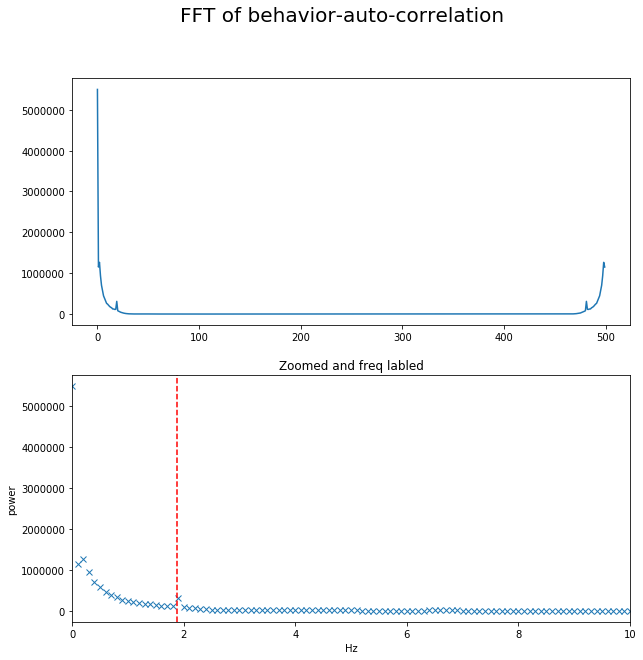

In [10]:
plt.figure(figsize=(10,10))
plt.suptitle('FFT of behavior-auto-correlation', fontsize=20)
plt.subplot(211)
plt.plot(bot)

plt.subplot(212)
plt.title('Zoomed and freq labled')
plt.plot(xf,np.abs(bot),'x')
plt.xlim(0,10)
plt.axvline(1/0.531995701,color='r',linestyle='--')
plt.xlabel('Hz')
plt.ylabel('power');

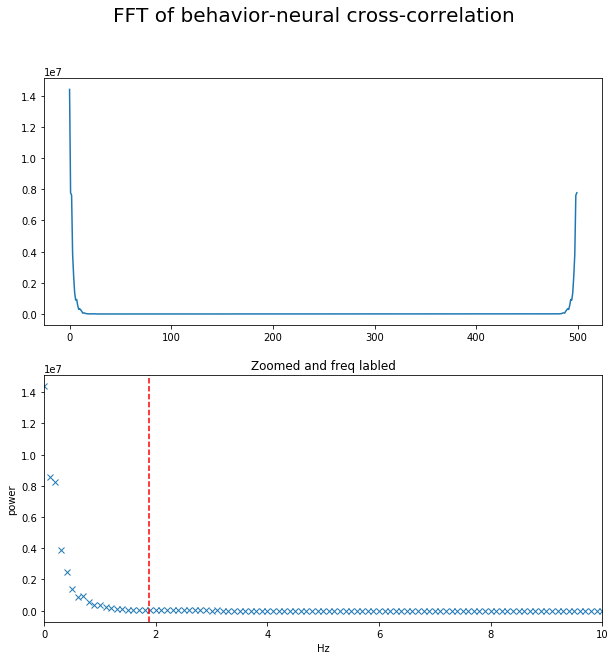

In [11]:
plt.figure(figsize=(10,10))
plt.suptitle('FFT of behavior-neural cross-correlation', fontsize=20)
plt.subplot(211)
plt.plot(top)

plt.subplot(212)
plt.title('Zoomed and freq labled')
plt.plot(xf,np.abs(top),'x')
plt.xlim(0,10)
plt.axvline(1/0.531995701,color='r',linestyle='--')
plt.xlabel('Hz')
plt.ylabel('power');

Text(0.5, 0, 'Hz')

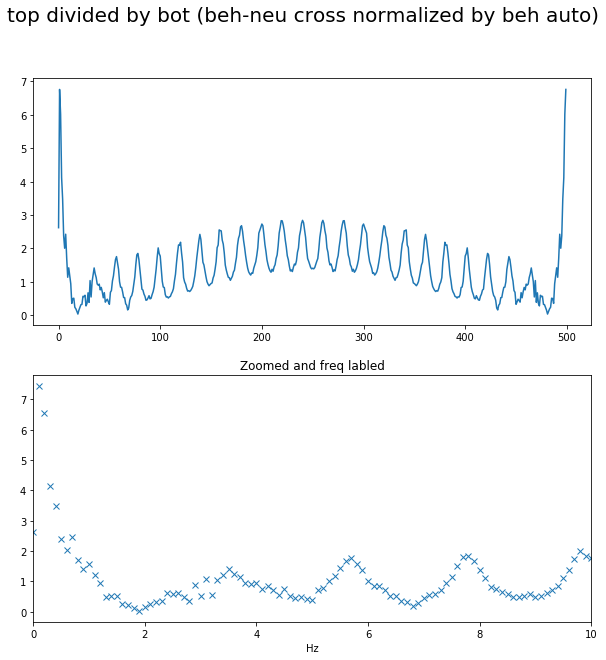

In [12]:
plt.figure(figsize=(10,10))
plt.suptitle('top divided by bot (beh-neu cross normalized by beh auto)', fontsize=20)
plt.subplot(211)
plt.plot(top/bot)

plt.subplot(212)
plt.title('Zoomed and freq labled')
plt.plot(xf,np.abs(top/bot),'x')
plt.xlim(0,10)
plt.xlabel('Hz')

Text(0.5, 0, 'Hz')

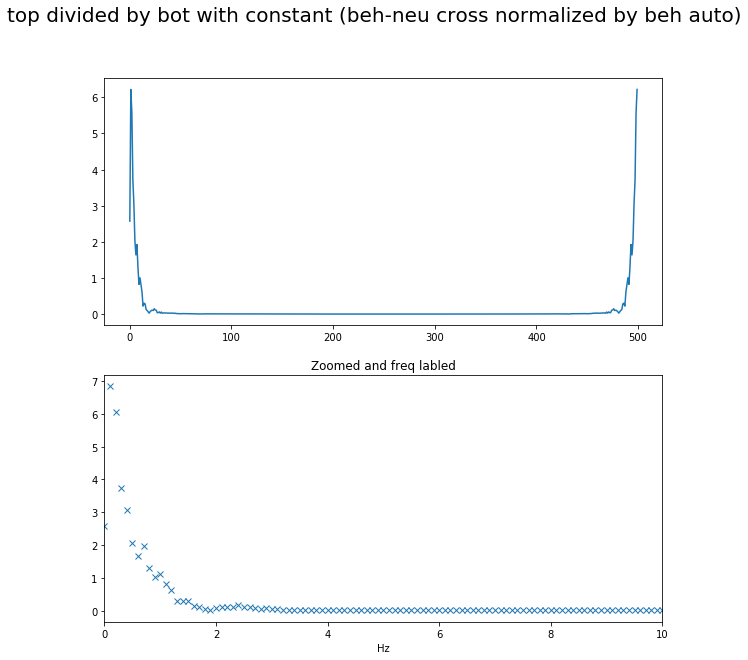

In [13]:
plt.figure(figsize=(10,10))
plt.suptitle('top divided by bot with constant (beh-neu cross normalized by beh auto)', fontsize=20)
plt.subplot(211)
plt.plot(top/(bot+100000))

plt.subplot(212)
plt.title('Zoomed and freq labled')
plt.plot(xf,np.abs(top/(bot+100000)),'x')
plt.xlim(0,10)
plt.xlabel('Hz')

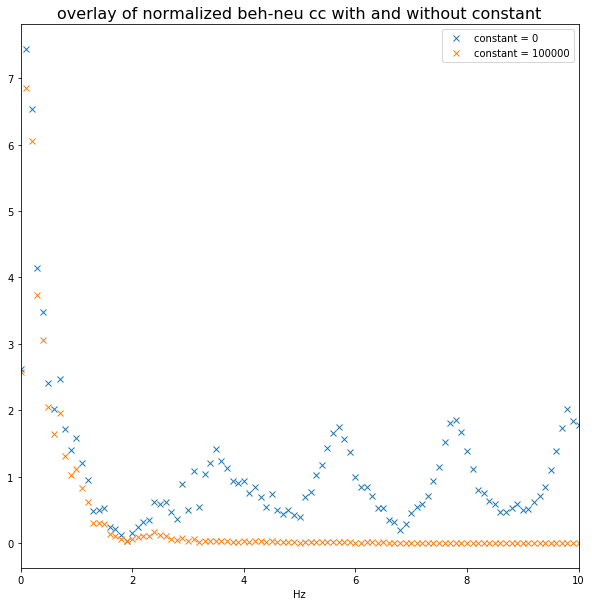

In [14]:
plt.figure(figsize=(10,10))
plt.title('overlay of normalized beh-neu cc with and without constant',fontsize=16)
plt.plot(xf,np.abs(top/(bot)),'x',label='constant = 0')
plt.plot(xf,np.abs(top/(bot+100000)),'x', label='constant = 100000')
plt.xlim(0,10)
plt.xlabel('Hz')
plt.legend()

# Visualize IFFT

Text(0.5, 0, 'sec')

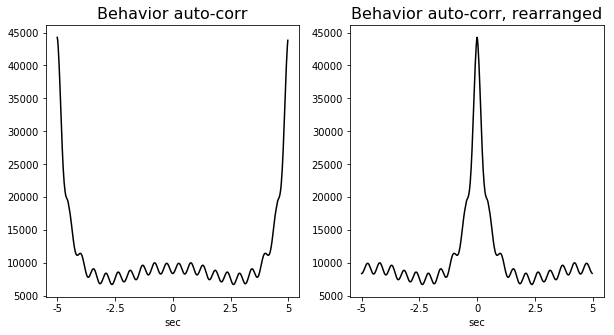

In [15]:
### Behavior auto-corr ###
# note the needed rearrangement - i don't know why this is
autocorr = ifft(bot)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(autocorr,color='k')
plt.title('Behavior auto-corr', fontsize=16)
plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5])
plt.xlabel('sec')

plt.subplot(122)
autocorr_ = np.concatenate((autocorr[-250:], autocorr[:250]))
plt.plot(autocorr_,color='k')
plt.title('Behavior auto-corr, rearranged', fontsize=16)
plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5])
plt.xlabel('sec')

Text(0.5, 0, 'sec')

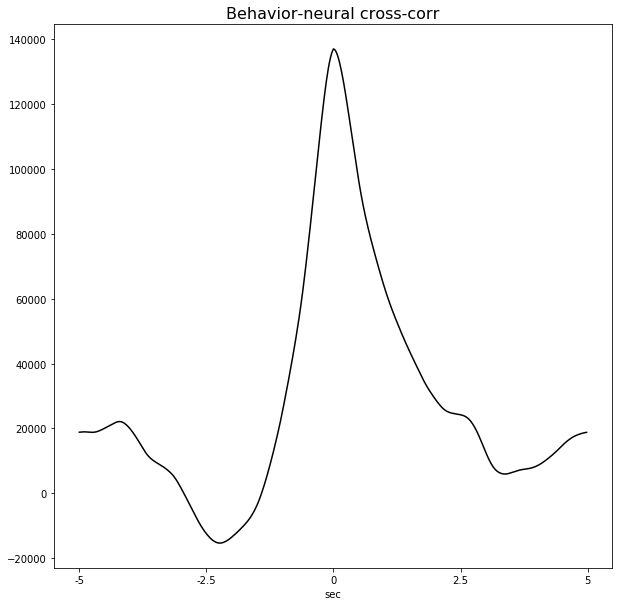

In [16]:
### Behavior-neural cross-corr
cc = ifft(top)
cc = np.concatenate((cc[-250:], cc[:250]))

plt.figure(figsize=(10,10))
plt.title('Behavior-neural cross-corr', fontsize=16)
plt.plot(cc,label='cc',color='k')
plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5])
plt.xlabel('sec')

Text(0.5, 1.0, 'constant sweep, normalized by max, zoom')

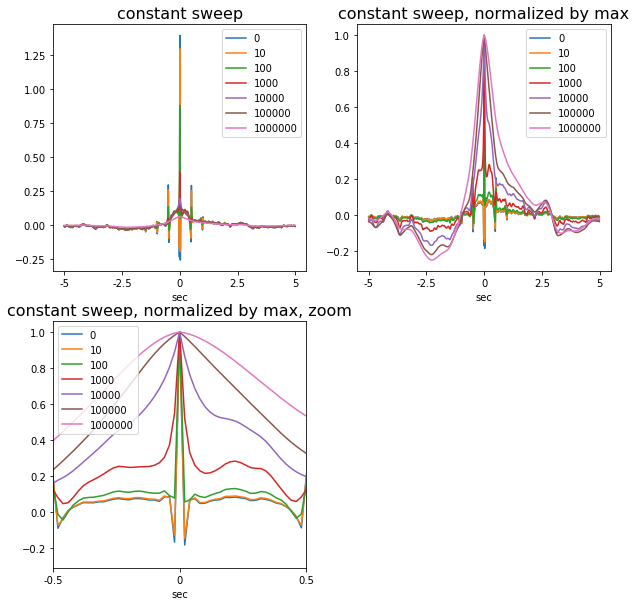

In [17]:
### Constant sweep
plt.figure(figsize=(10,10))
plt.subplot(221)
for i in [0,10,100,1000,10000,100000,1000000]:
    cc_norm = ifft(top/(bot+i))
    cc_norm = np.concatenate((cc_norm[-250:], cc_norm[:250]))
    plt.plot(cc_norm,label=i)
plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5])
plt.xlabel('sec')
plt.legend()
plt.title('constant sweep',fontsize=16)

plt.subplot(222)
for i in [0,10,100,1000,10000,100000,1000000]:
    cc_norm = ifft(top/(bot+i))
    cc_norm = np.concatenate((cc_norm[-250:], cc_norm[:250]))
    plt.plot(cc_norm/np.max(cc_norm),label=i)
plt.xticks([0,125,250,375,500],[-5,-2.5,0,2.5,5])
plt.xlabel('sec')
plt.legend()
plt.title('constant sweep, normalized by max',fontsize=16)

plt.subplot(223)
for i in [0,10,100,1000,10000,100000,1000000]:
    cc_norm = ifft(top/(bot+i))
    cc_norm = np.concatenate((cc_norm[-250:], cc_norm[:250]))
    plt.plot(cc_norm/np.max(cc_norm),label=i)
plt.xticks([225,250,275],[-.5,0,.5])
plt.xlabel('sec')
plt.xlim(225,275)
plt.legend()
plt.title('constant sweep, normalized by max, zoom',fontsize=16)

# Comparing this cross-corr filter to an alternate approach: neural weighted average behavior. This method uses no interpolation of the neural data, rather for each neural datum the flanking behavior is averaged.

In [18]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X.npy'
behavior_windows = np.load(load_file)
print(f'behavior_windows is a matrix of behavior flanking each neural datum: {behavior_windows.shape}')

behavior_windows is a matrix of behavior flanking each neural datum: (30456, 500)


In [19]:
neural.shape

(30456,)

In [23]:
neuwebeh_filter = np.dot(behavior_windows.T, neural)[::-1]

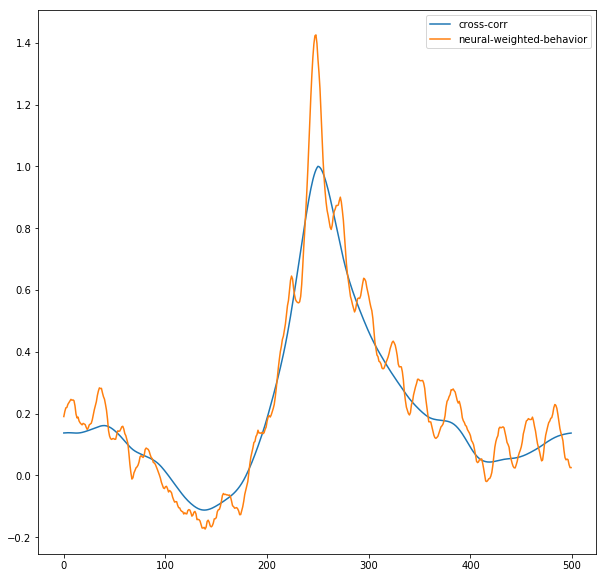

In [24]:
plt.figure(figsize=(10,10))
plt.plot(cc/np.max(cc), label='cross-corr')
plt.plot(neuwebeh_filter/10, label='neural-weighted-behavior')
plt.legend()

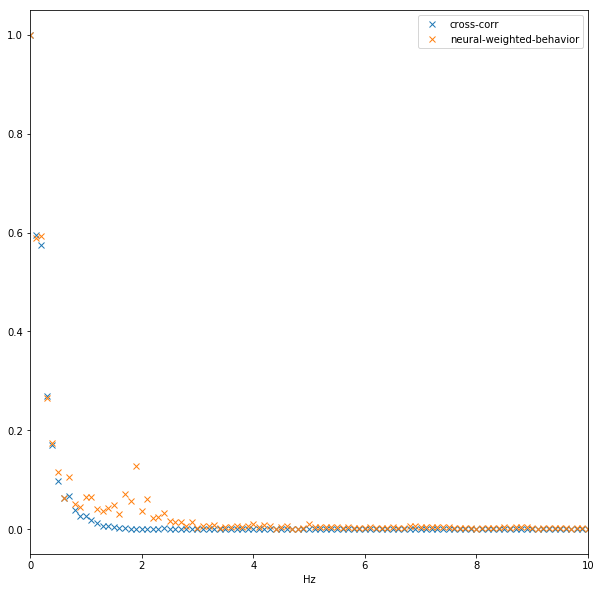

In [35]:
plt.figure(figsize=(10,10))
cc_fft = fft(cc)
neuwebeh_filter_fft = fft(neuwebeh_filter)

plt.plot(xf,np.abs(cc_fft)/np.max(cc_fft),'x',label='cross-corr')
plt.plot(xf,np.abs(neuwebeh_filter_fft)/np.max(neuwebeh_filter_fft),'x',label='neural-weighted-behavior')
plt.xlim(0,10)
plt.xlabel('Hz')
plt.legend()